In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
import re

from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.preprocessing import StandardScaler

stop_words = STOP_WORDS
import string
punctuations = string.punctuation
from gensim.models import Word2Vec

from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from sklearn.naive_bayes import MultinomialNB

In [2]:
real_news = pd.read_csv('/content/True.csv')

In [6]:
fake_news = pd.read_csv('/content/Fake.csv')

In [7]:
real_news.shape

(3703, 4)

In [8]:
fake_news.shape

(23481, 4)

In [9]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [10]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
real_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703 entries, 0 to 3702
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    3703 non-null   object
 1   text     3703 non-null   object
 2   subject  3702 non-null   object
 3   date     3702 non-null   object
dtypes: object(4)
memory usage: 115.8+ KB


In [12]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


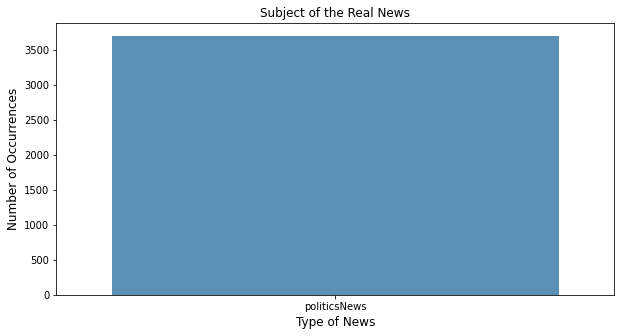

In [13]:
real_subject_count=real_news['subject'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(real_subject_count.index, real_subject_count.values, alpha=0.8)
plt.title('Subject of the Real News')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type of News', fontsize=12)
plt.show()

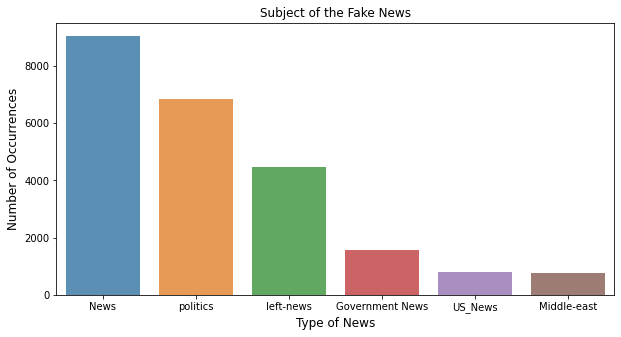

In [14]:
fake_subject_count=fake_news.subject.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(fake_subject_count.index, fake_subject_count.values, alpha=0.8)
plt.title('Subject of the Fake News')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type of News', fontsize=12)
plt.show()

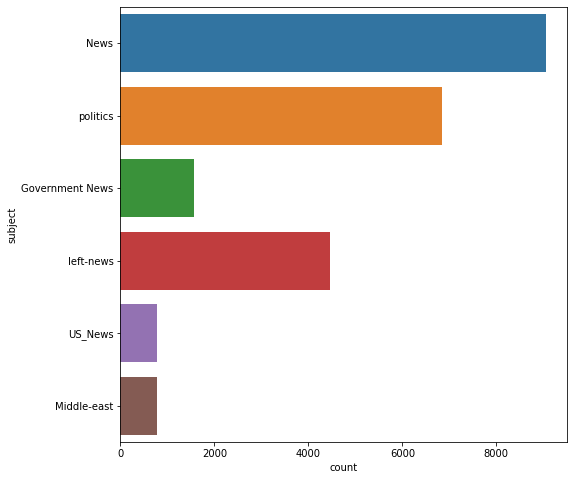

In [15]:
plt.figure(figsize=(8,8))
sns.countplot(y='subject', data = fake_news)

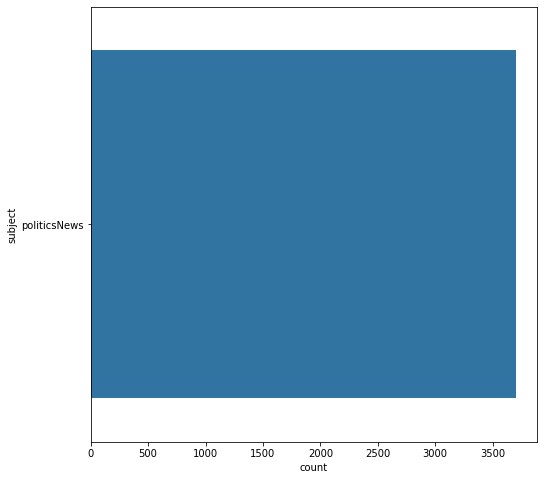

In [16]:
plt.figure(figsize=(8,8))
sns.countplot(y='subject', data = real_news)

(-0.5, 399.5, 199.5, -0.5)

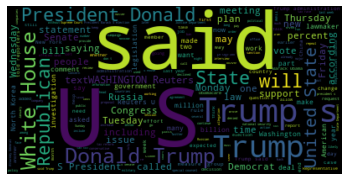

In [17]:
from wordcloud import WordCloud
wc = WordCloud().generate('text'.join(real_news['text']))
2
plt.imshow(wc, interpolation="bilinear")
3
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

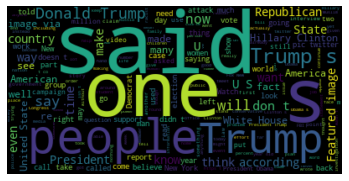

In [18]:
from wordcloud import WordCloud
wc = WordCloud().generate('text'.join(fake_news['text']))
2
plt.imshow(wc, interpolation="bilinear")
3
plt.axis('off')

In [19]:
real_news1=real_news[real_news['subject']=='politicsNews']
fake_news1=fake_news[fake_news['subject'].isin(['politics','Government News', 'US_News'])].reset_index(drop=True)

In [20]:
fake_news1.subject.value_counts(), real_news1.subject.value_counts()

(politics           6841
 Government News    1570
 US_News             783
 Name: subject, dtype: int64, politicsNews    3702
 Name: subject, dtype: int64)

In [21]:
empty_real_index = [index for index,text in enumerate(real_news1.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_real_index)}")
real_news1.iloc[empty_real_index].tail()

No of empty rows: 0


,title,text,subject,date


In [22]:
empty_fake_index = [index for index,text in enumerate(fake_news1.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake_news1.iloc[empty_fake_index].tail()

No of empty rows: 480


,title,text,subject,date
8312,(VIDEO)MILWAUKEE SHERIFF DAVID CLARKE HAMMERS ...,,Government News,"May 8, 2015"
8323,BLACK REPUBLICAN AND BRILLIANT NEUROSURGEON AN...,,Government News,"May 5, 2015"
8325,(VIDEO)INCREDIBLE ACCOUNT FROM SHERIFF MICHAEL...,,Government News,"May 4, 2015"
8337,(VIDEO) RIOTERS TAKE SELFIES WITH TORCHED POLI...,,Government News,"Apr 27, 2015"
8368,TREY GOWDY TO DEA CHIEF ON MISCONDUCT: “WHAT T...,,Government News,"Apr 14, 2015"


In [159]:
#real_news1 = real_news1.drop(8970, axis=0)

In [161]:
#fill the emtpy dataset with the empty string
fake_news1 = fake_news1.fillna('')

In [162]:
fake_news1.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [24]:
empty_real_index = [index for index,text in enumerate(real_news1.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_real_index)}")
real_news1.iloc[empty_real_index].tail()

No of empty rows: 0


,title,text,subject,date


In [25]:
real_news1['source'] =real_news1.text.str.slice(10, 20)
print(real_news1)

                                                  title  \
0     As U.S. budget fight looms, Republicans flip t...   
1     U.S. military to accept transgender recruits o...   
2     Senior U.S. Republican senator: 'Let Mr. Muell...   
3     FBI Russia probe helped by Australian diplomat...   
4     Trump wants Postal Service to charge 'much mor...   
...                                                 ...   
3697  For Trump's defenders, White House turmoil is ...   
3698  Democratic attorneys general seek to intervene...   
3699  Treasury's Mnuchin concerned about alternate s...   
3700  U.S. Treasury vows no special treatment for Tr...   
3701  Treasury Secretary says Trump has approved new...   

                                                   text       subject  \
0     WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1     WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2     WASHINGTON (Reuters) - The special counsel inv...  politicsNews   

In [26]:
real_news1.source.value_counts()

 (Reuters)    2241
Reuters) -     175
euters) -      153
ing statem      77
uters) - T      41
              ... 
- U.S. dem       1
ters) - Sa       1
- U.S. Hou       1
- U.S. leg       1
- World ch       1
Name: source, Length: 414, dtype: int64

In [27]:
real_news1.subject.value_counts()

politicsNews    3702
Name: subject, dtype: int64

In [28]:
real_news1['label']=1
fake_news1['label']=0

In [29]:
real_news1.head()

,title,text,subject,date,source,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",(Reuters),1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",(Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",(Reuters),1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",(Reuters),1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",SHINGTON (,1


In [30]:
fake_news1.head()

,title,text,subject,date,label
0,Democrat Senator Warns Mueller Not To Release ...,"According to The Hill, Democrat Senator Bob Ca...",politics,19-Feb-18,0
1,MSNBC ANCHOR Flabbergasted at What Texas Teach...,If we protect every other government building ...,politics,19-Feb-18,0
2,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,Ami Horowitz is fantastic! Check out this man ...,politics,19-Feb-18,0
3,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,Just one more reminder of why President Trump ...,politics,18-Feb-18,0
4,DOJ’s JEFF SESSIONS Opens Investigation Into W...,Thank goodnesss Jeff Sessions is moving on fin...,politics,18-Feb-18,0


In [31]:
fake_news1['title'][1]

'MSNBC ANCHOR Flabbergasted at What Texas Teachers Do to Protect Their Students [Video]'

In [32]:
fake_news1['text'][1]

'If we protect every other government building or public venue with armed guards, why shouldn t our schools be protected with armed teachers? A Texas Sheriff shocked an MSNBC host when he discussed how he prepares local teachers to be armed in the classroom. common sense solution? You betcha!Sheriff Paul Cairney of Argyle, Texas, described the process by which staff members can carry firearms in the school district. The Sheriff said that the staff at the school who choose to carry a firearm go through an intense round of interviews and training before they are allowed to carry on campus. The MSNBC host was flabbergasted at the practice and asked the Sheriff about concerns for the safety of the students in the school when there are firearms around.Sheriff Cairney:  The time to do nothing is over THE PROCESS TO BECOME A SCHOOL MARSHALL:To become a school marshal, those employees must undergo extensive active shooter and firearms training with the state. They must also undergo a mental he

In [33]:
news_df = real_news1.append(fake_news1, ignore_index=True)

In [34]:
news_df.shape

(12896, 6)

In [35]:
news_df.head()

,title,text,subject,date,source,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",(Reuters),1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",(Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",(Reuters),1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",(Reuters),1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",SHINGTON (,1


subject
Government News    1570
US_News             783
politics           6841
politicsNews       3702
Name: text, dtype: int64


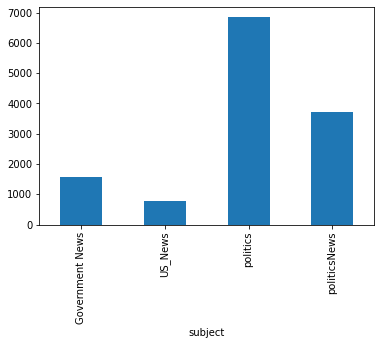

In [36]:
print(news_df.groupby(['subject'])['text'].count())
news_df.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

label
0    9194
1    3702
Name: text, dtype: int64


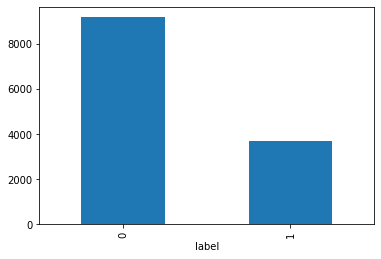

In [37]:
print(news_df.groupby(['label'])['text'].count())
news_df.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

0    9194
1    3702
Name: label, dtype: int64


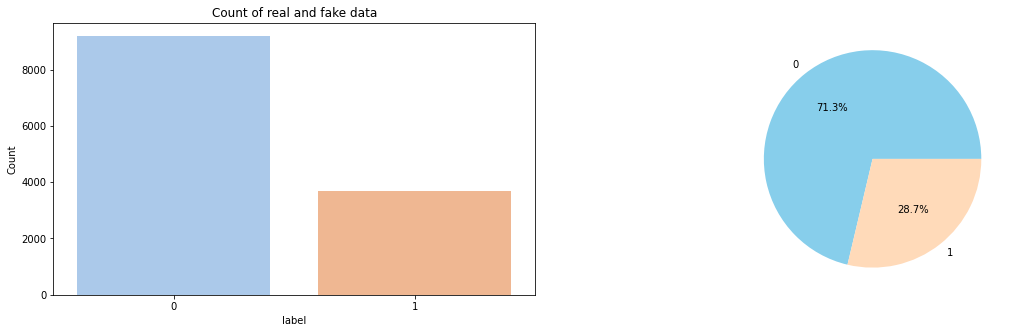

In [38]:
print(news_df["label"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(news_df.label,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("label")
g2 = plt.pie(news_df["label"].value_counts().values,explode=[0,0],labels=news_df.label.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

politics           6841
politicsNews       3702
Government News    1570
US_News             783
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

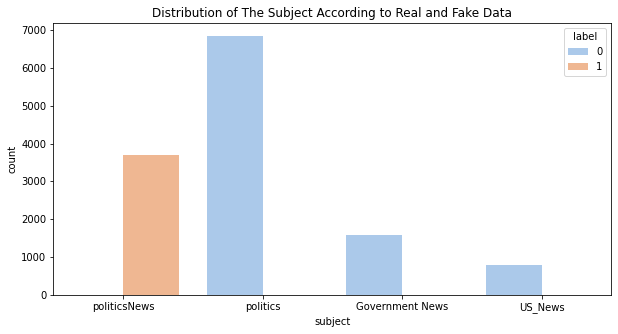

In [39]:
print(news_df.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='label', data=news_df, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

In [40]:
import nltk
# let's see the 10 most words used in text:
freq = nltk.FreqDist(' '.join(news_df['text']).split())

freq.most_common(10)

[('the', 258173),
 ('to', 147475),
 ('of', 120816),
 ('and', 110088),
 ('a', 105113),
 ('in', 85502),
 ('that', 61368),
 ('on', 47888),
 ('for', 46670),
 ('is', 43751)]

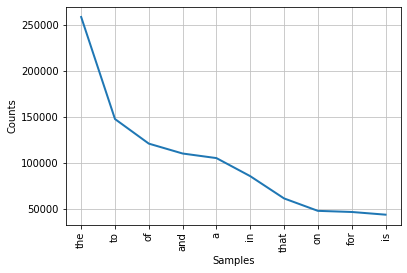

In [41]:
freq.plot(10)

In [42]:
import nltk
# let's see the 10 most words used in title:
freq1 = nltk.FreqDist(' '.join(news_df['title']).split())

freq1.most_common(10)

[('To', 2591),
 ('Trump', 2549),
 ('to', 2208),
 ('[Video]', 2065),
 ('[VIDEO]', 1338),
 ('In', 1307),
 ('U.S.', 1306),
 ('The', 1300),
 ('For', 1298),
 ('Of', 1220)]

In [43]:
from nltk import FreqDist
# 10 least used words:
last_ten = FreqDist(dict(freq.most_common()[-10:]))
last_ten

FreqDist({'Die,': 1, 'die!': 1, '(regardless,': 1, 'scary).': 1, 'DUAL': 1, 'LOYALTIES:': 1, 'Mondoweiss,': 1, 'IDF.': 1, 'towards,': 1, 'overdrive.READ': 1})

In [44]:
from nltk import FreqDist
# 10 least used words:
last_ten1 = FreqDist(dict(freq1.most_common()[-10:]))
last_ten1

FreqDist({'Narrative’': 1, 'Burns,': 1, 'Retreat,': 1, '#38': 1, 'Showdown': 1, 'Looms': 1, 'Ranching': 1, 'Bundys': 1, 'Troubled': 1, 'King:': 1})

In [45]:
news_df.head()

,title,text,subject,date,source,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",(Reuters),1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",(Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",(Reuters),1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",(Reuters),1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",SHINGTON (,1


In [46]:
# Removing the un-important columns

news_df=news_df[['title','text','label']]

In [47]:
news_df.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [48]:
# in order to remove bias I will shuffle the data
from sklearn.utils import shuffle
news_df = shuffle(news_df)
news_df = news_df.reset_index(drop=True)
news_df

,title,text,label
0,(VIDEO) LAWYER FOR “Patriot” Gyrocopter Mailma...,"I m Doug Hughes, I m 61 years old and I m a m...",0
1,BREAKING: DNC CHARWOMAN Shouted Down In Chaos ...,DNC Chairwoman shouted down during opening rem...,0
2,Is Spicer Flap a Cover for Media to Tie Up Whi...,By The TRUTH HOUNDIn the words of ABC News an...,0
3,Democrat wins by one vote in Virginia legislat...,(Corrects spelling of Virginia House of Deleg...,1
4,KID ROCK BAND MEMBER PREDICTS: ‘That F*cker Co...,Kid Rock Keyboardist Jimmie Bones is shocked b...,0
...,...,...,...
12891,INTEL WHISTLEBLOWER: Trump was likely spied on...,,0
12892,"More Americans think wealthy, not middle class...",WASHINGTON (Reuters) - Americans are more like...,1
12893,HOUSE DEMOCRATS MAKE STUNNING Move To Implemen...,While US citizens are outraged over the remova...,0
12894,BEWARE OF HILLARY CLINTON’S “Smart Power” Fore...,What the heck is Hillary Clinton talking about...,0


In [49]:
news_df['text'] = news_df['text'].apply(lambda x: x.lower())
news_df['title'] = news_df['title'].apply(lambda x: x.lower())
# Remove punctuation:
import string
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
news_df['text'] = news_df['text'].apply(punctuation_removal)

In [50]:
def punctuation_removal(title):
    all_list = [char for char in title if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
news_df['title'] = news_df['title'].apply(punctuation_removal)

In [51]:
news_df

,title,text,label
0,video lawyer for “patriot” gyrocopter mailman ...,i m doug hughes i m 61 years old and i m a ma...,0
1,breaking dnc charwoman shouted down in chaos d...,dnc chairwoman shouted down during opening rem...,0
2,is spicer flap a cover for media to tie up whi...,by the truth houndin the words of abc news an...,0
3,democrat wins by one vote in virginia legislat...,corrects spelling of virginia house of delega...,1
4,kid rock band member predicts ‘that fcker coul...,kid rock keyboardist jimmie bones is shocked b...,0
...,...,...,...
12891,intel whistleblower trump was likely spied on ...,,0
12892,more americans think wealthy not middle class ...,washington reuters americans are more likely ...,1
12893,house democrats make stunning move to implemen...,while us citizens are outraged over the remova...,0
12894,beware of hillary clinton’s “smart power” fore...,what the heck is hillary clinton talking about...,0


In [52]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('all')
#establish the lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
news_df['text'] = news_df.text.apply(lambda x: " ".join(wordnet_lemmatizer.lemmatize(w) for w in x.split()))
news_df.head(10)


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

,title,text,label
0,video lawyer for “patriot” gyrocopter mailman ...,i m doug hughes i m 61 year old and i m a mail...,0
1,breaking dnc charwoman shouted down in chaos d...,dnc chairwoman shouted down during opening rem...,0
2,is spicer flap a cover for media to tie up whi...,by the truth houndin the word of abc news anch...,0
3,democrat wins by one vote in virginia legislat...,corrects spelling of virginia house of delegat...,1
4,kid rock band member predicts ‘that fcker coul...,kid rock keyboardist jimmie bone is shocked bu...,0
5,our crybaby community organizer makes a fool o...,,0
6,nervous nancy pelosi gives incoherent response...,a nervous nancy pelosi responded thursday to c...,0
7,breaking fbi didn’t record hillary interview d...,no worry fbi director james comey is ha assure...,0
8,churchgoers trapped inside cathedral after man...,france s armed police officer were at least pr...,0
9,kremlin russia did not use facebook adverts to...,moscow reuters russia did not place advert on ...,1


In [53]:
# genrate the token list:
token = ' '.join(news_df.text).split()

In [54]:
# creating the bigrams
ngrams_2 = nltk.bigrams(token)

# freq distribution for these
freq_2grams = pd.Series(ngrams_2).value_counts().to_dict()
list(freq_2grams.items())[:20]

[(('of', 'the'), 28758),
 (('in', 'the'), 21890),
 (('to', 'the'), 15137),
 (('on', 'the'), 10208),
 (('for', 'the'), 8539),
 (('in', 'a'), 7590),
 (('and', 'the'), 7411),
 (('that', 'the'), 7301),
 (('at', 'the'), 6875),
 (('to', 'be'), 6848),
 (('the', 'u'), 6783),
 (('with', 'the'), 6668),
 (('by', 'the'), 6046),
 (('from', 'the'), 5546),
 (('it', 's'), 5214),
 (('white', 'house'), 5036),
 (('the', 'united'), 5026),
 (('donald', 'trump'), 4857),
 (('of', 'a'), 4854),
 (('a', 'a'), 4627)]

In [55]:
# creating the trigrams
ngrams_3 = nltk.trigrams(token)

# freq distribution for these
freq_3grams = pd.Series(ngrams_3).value_counts().to_dict()
list(freq_3grams.items())[:20]

[(('the', 'united', 'state'), 4256),
 (('the', 'white', 'house'), 3128),
 (('president', 'donald', 'trump'), 2295),
 (('one', 'of', 'the'), 1803),
 (('said', 'in', 'a'), 1561),
 (('in', 'a', 'statement'), 1267),
 (('secretary', 'of', 'state'), 1162),
 (('a', 'well', 'a'), 1150),
 (('according', 'to', 'the'), 1081),
 (('member', 'of', 'the'), 963),
 (('house', 'of', 'representative'), 963),
 (('21st', 'century', 'wire'), 954),
 (('in', 'the', 'u'), 954),
 (('the', 'obama', 'administration'), 943),
 (('u', 'president', 'donald'), 910),
 (('in', 'the', 'united'), 897),
 (('part', 'of', 'the'), 856),
 (('the', 'trump', 'administration'), 849),
 (('the', 'new', 'york'), 794),
 (('i', 'don', 't'), 779)]

In [56]:
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(news_df[['title','text']], 
                                                    news_df['label'],  
                                                    test_size = 0.2)

In [57]:
X_train.head()

,title,text
6389,video staffer pleading fifth on emails ‘anothe...,bryan pagliano is in hot water with this and h...
10039,boiler room ep 119 – zombie disneyland the de...,tune in to the alternate current radio network...
12180,bernie sues to allow 17 year olds to vote,next up is a law suit to make it legal for h1b...
174,wow total clown john kasich blasts trump…invit...,ohio governor john kasich dreamer didn t choos...
2629,assange ‘trump in conflict with cia over syria...,this interview with wikileaks head julian assa...


In [58]:
X_train.tail()

,title,text
6613,watch and laugh sebastian gorka tells cnn’s ca...,sebastian gorka doe a mic drop on cnn anchor a...
11981,video screaming ‘dreamers’ force a shaken nanc...,wow the left ha lost control of their precious...
9901,hillary plays victim card…here’s why that’s no...,the clinton always blame somebody else now it ...
12889,40 years ago ronald reagan warned us about oba...,i d like to suggest that there is no such thin...
12735,what’s the leading killer of american adults u...,21st century wire say last april the un genera...


In [59]:
#Since title is also important so combining it with the text

train_data= np.asarray(list(X_train['title']+" "+X_train['text']))
test_data = np.asarray(list(x_test['title']+" "+x_test['text']))

In [60]:
train_data[0]

'video staffer pleading fifth on emails ‘another blow’ to hillary bryan pagliano is in hot water with this and he know it is water boarding an option here seriously they need his testimony but he s obviously not going to incriminate himself so he pleads the fifththe state department it worker who managed hillary clinton s private email server while she wa secretary of state will plead the fifth amendment if called to testify about his work on the democratic presidential candidate s mysterious email setup his attorney informed the house select committee on benghazi this week the committee subpoenaed bryan pagliano on aug 11 according to the washington post in addition to testifying on sept 10 committee chairman trey gowdy asked pagliano to produce document related to the server he managed on behalf of clinton pagliano worked on clinton s 2008 presidential campaign before moving over to the state department in may 2009 several month after clinton took office he left the agency at the sam

In [61]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [62]:
from tqdm import tqdm
# tqdm is for printing the status bar
# Getting list of stop words fron nltk
en_stops = set(stopwords.words('english'))

def process(data):
    preprocessed_tweets = []

    for sentance in tqdm(data):
        sentance = re.sub(r"http\S+", "", sentance) # removing the html tags
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in en_stops)
        preprocessed_tweets.append(sentance.strip())
        
    return preprocessed_tweets

In [63]:
preprocess_train_data=process(train_data)
preprocess_test_data=process(test_data)

100%|██████████| 2580/2580 [00:01<00:00, 1722.60it/s]


In [64]:
# Tokenizing the train data sentence

cleaned_train_data=[]
for sent in preprocess_train_data:
    cleaned_train_data.append(sent.split()) 

In [65]:
# Tokenizing the test data sentence
cleaned_test_data =[]   
for sent in preprocess_test_data:
    cleaned_test_data.append(sent.split())

In [66]:
cleaned_train_data[0][:10]

['video',
 'staffer',
 'pleading',
 'fifth',
 'emails',
 'another',
 'blow',
 'hillary',
 'bryan',
 'pagliano']

In [67]:
# Creating a word2vec model on the dataset
# vector_size -Dimensionality of the word vectors. 
# min_count – Ignores all words with total frequency lower than this.
# sg  – Training algorithm: 1 for skip-gram; otherwise CBOW.
# window – Maximum distance between the current and predicted word within a sentence

word2vec_model=Word2Vec(cleaned_train_data,size=300,min_count=1,workers=3, window =3, sg = 1)

In [68]:
#creating function to calculate the average word vectorizer

def Word2Vectorizer(data,model,size):
    vectors = []
    for sent in data:
        sent_vec = np.zeros(size)
        cnt_words = 0
        for word in sent:
            try:
                vec = model.wv[word]  # getting the vector corresponding to the word
                sent_vec += vec       # Adding the vectors of all the words present in sentence
                cnt_words += 1        # counting the number of words
            except:
                pass
        if cnt_words!=0:    
            sent_vec /= cnt_words
        vectors.append(sent_vec)
    return np.nan_to_num(vectors)

In [69]:
train_av_w2v=Word2Vectorizer(cleaned_train_data,word2vec_model,300)
test_av_w2v=Word2Vectorizer(cleaned_test_data,word2vec_model,300)

In [70]:
word2vec_model.wv.most_similar("saudi")

[('arabia', 0.9376716613769531),
 ('qatar', 0.8002569675445557),
 ('uae', 0.7887697219848633),
 ('bahrain', 0.7767956256866455),
 ('qatari', 0.7700132131576538),
 ('riyadh', 0.7650140523910522),
 ('arabian', 0.7637085914611816),
 ('egypt', 0.747124195098877),
 ('thenadvanced', 0.743314266204834),
 ('monarch', 0.7415539026260376)]

In [71]:
train_av_w2v[1]

array([-2.14700921e-01, -6.47407329e-02,  3.10745910e-02, -1.98817005e-01,
        1.26875652e-01,  1.12317321e-01,  3.93548528e-02,  2.58624531e-01,
       -2.73649015e-01,  1.38162822e-01,  1.67160744e-01, -1.73132746e-01,
        3.48619182e-02,  2.63568265e-02,  1.39009765e-01,  9.86827659e-02,
        1.96912785e-01, -1.99977395e-03,  1.72004339e-01,  5.41667678e-02,
       -1.23247487e-02,  1.15107206e-01,  1.89266057e-01,  3.55181550e-01,
       -3.19167294e-05,  3.05867969e-02, -1.32292132e-01,  1.61337155e-01,
        1.17793080e-01,  6.26787257e-02, -1.02155284e-02, -1.46153894e-01,
        8.45883260e-02, -1.25831406e-01,  4.78503956e-01, -2.72081283e-02,
       -1.93323251e-01,  2.35423479e-02, -6.85717146e-02, -1.95994653e-01,
       -4.62115133e-02,  7.37899649e-02,  2.59115423e-01,  8.97876467e-02,
        1.84008306e-01, -1.16544909e-01, -2.20676909e-02, -1.52556117e-01,
       -2.36829256e-01, -8.19178141e-02,  3.68213246e-02, -1.71681876e-01,
        1.29091814e-01,  

In [72]:
# combining the processed text data with dependent variable
processed_data=pd.DataFrame(train_av_w2v)
processed_data['label']=news_df['label']

In [73]:
# Saving the processed train data

processed_data.to_csv('final_train.csv',index=False)

In [74]:
X_train=train_av_w2v
x_test=test_av_w2v

In [75]:
def trainconfusionmatrix(model,X_train,y_train):
    print("Confusion Matrix for Train set")
    cm=confusion_matrix(y_train, model.predict(X_train))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Train Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [76]:
def testconfusionmatrix(model,X_test,y_test):
    print("Confusion Matrix for Test set")
    cm=confusion_matrix(y_test, model.predict(X_test))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Test Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [77]:
def Grid_SearchCV(model,X_train,Y_train,param_grid):
    
    tscv = TimeSeriesSplit(n_splits=10)
    
    gsv=GridSearchCV(model,param_grid,cv=tscv,verbose=1,scoring='f1')
    gsv.fit(X_train,Y_train)
    
    return gsv

In [78]:
#Finding the best value Of hyperparameter

from sklearn.ensemble import RandomForestClassifier

param_grid= {'max_depth':[1,5,10,50,100,500,1000],
             'n_estimators' :[5,10,20,50,100]
            }

gsv=Grid_SearchCV(RandomForestClassifier(class_weight='balanced'),X_train,Y_train,param_grid)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best HyperParameter:  {'max_depth': 500, 'n_estimators': 100}
Best Accuracy: 92.46%


In [79]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
n_estimator =Best_Param['n_estimators']
Model_Random_Forest=RandomForestClassifier(max_depth=depth,n_estimators=n_estimator,class_weight="balanced")
Model_Random_Forest.fit(X_train,Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=500)

Confusion Matrix for Train set


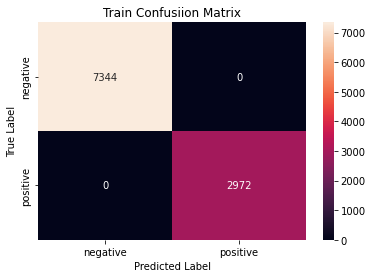

In [80]:
trainconfusionmatrix(Model_Random_Forest,X_train,Y_train)

Confusion Matrix for Test set


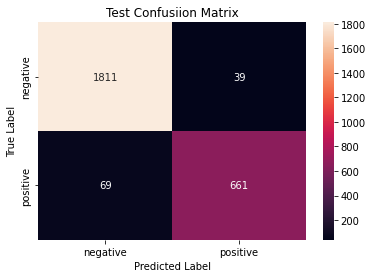

In [81]:
testconfusionmatrix(Model_Random_Forest,x_test,y_test)


In [82]:
print("Train Classification Report: \n")
y_pred_train=Model_Random_Forest.predict(X_train)
print(classification_report(Y_train, y_pred_train))

Train Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7344
           1       1.00      1.00      1.00      2972

    accuracy                           1.00     10316
   macro avg       1.00      1.00      1.00     10316
weighted avg       1.00      1.00      1.00     10316



In [83]:
print("Test Classification Report: \n")
y_pred_test=Model_Random_Forest.predict(x_test)
print(classification_report(y_test, y_pred_test))

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1850
           1       0.94      0.91      0.92       730

    accuracy                           0.96      2580
   macro avg       0.95      0.94      0.95      2580
weighted avg       0.96      0.96      0.96      2580



In [84]:
from xgboost import XGBClassifier

param_grid= {'max_depth':[1,5,10,50,100,500,1000],
              'n_estimators' :[5,10,20,50,100]
            }


gsv=Grid_SearchCV(XGBClassifier(),X_train,Y_train,param_grid)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 35 candidates, totalling 350 fits
Best HyperParameter:  {'max_depth': 5, 'n_estimators': 100}
Best Accuracy: 94.47%


In [85]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
n_estimator =Best_Param['n_estimators']
Model_XGB=XGBClassifier(max_depth=depth,n_estimators=n_estimator,class_weight="balanced")
Model_XGB.fit(X_train,Y_train)

XGBClassifier(class_weight='balanced', max_depth=5)

Confusion Matrix for Train set


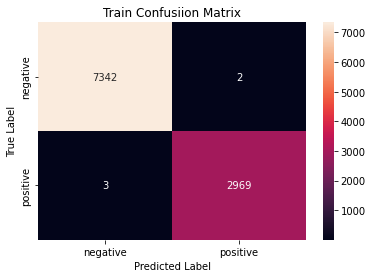

In [86]:
trainconfusionmatrix(Model_XGB,X_train,Y_train)

Confusion Matrix for Test set


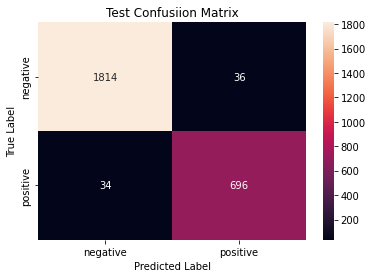

In [87]:
testconfusionmatrix(Model_XGB,x_test,y_test)

In [88]:
print("Train Classification Report: \n")
y_pred_train=Model_XGB.predict(X_train)
print(classification_report(Y_train, y_pred_train))

Train Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7344
           1       1.00      1.00      1.00      2972

    accuracy                           1.00     10316
   macro avg       1.00      1.00      1.00     10316
weighted avg       1.00      1.00      1.00     10316



In [89]:
print("Test Classification Report: \n")
y_pred_test2=Model_XGB.predict(x_test)
print(classification_report(y_test, y_pred_test))

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1850
           1       0.94      0.91      0.92       730

    accuracy                           0.96      2580
   macro avg       0.95      0.94      0.95      2580
weighted avg       0.96      0.96      0.96      2580



In [90]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Accuracy = logreg.score(x_test, y_test)
print(Accuracy*100)

96.43410852713178


In [91]:
print("Test Classification Report: \n")
y_pred_test1=logreg.predict(x_test)
print(classification_report(y_test, y_pred_test1))

Test Classification Report: 

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1850
           1       0.94      0.93      0.94       730

    accuracy                           0.96      2580
   macro avg       0.96      0.95      0.96      2580
weighted avg       0.96      0.96      0.96      2580



Confusion Matrix for Test set


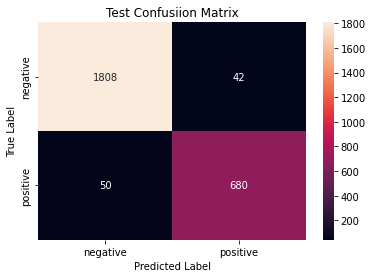

In [92]:
testconfusionmatrix(logreg,x_test,y_test)

In [93]:
from joblib import Parallel, delayed
import joblib
  
joblib.dump(Model_Random_Forest, 'Model_Random_Forest.pkl')

['Model_Random_Forest.pkl']

In [94]:
joblib.dump(Model_XGB, 'Model_XGB.pkl')

['Model_XGB.pkl']

In [95]:
joblib.dump(logreg, 'Model_logreg.pkl')

['Model_logreg.pkl']

In [103]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests

#url = "https://edition.cnn.com/2022/09/16/politics/donald-trump-hugh-hewitt-interview-indicted/index.html"
url = "https://edition.cnn.com/2022/12/07/politics/georgia-senate-runoff-takeaways/index.html"

# To fetch the url
#html = requests.get(url)

html = urlopen(url)

# Using beautiful soup to pull the html data 
soup = BeautifulSoup(html,"html.parser")

# finding the tag in which the content is present
a = soup.findAll("p",class_="paragraph inline-placeholder")

# Adding all the data in a lists
l=[]

for x in a[2:]:
    l.append(x.text.strip("\n"))
    
data=pd.DataFrame(l,columns=['text'])

In [158]:
data['text'][1]

'His victory in this head-to-head contest with Republican nominee Herschel Walker means Democrats will add to their already-secured Senate majority, with 51 seats to the GOP’s 49, and solidify the Peach State as a potentially decisive 2024 presidential battleground.  \n  '

In [105]:
df1 = pd.DataFrame.from_records(data)
df1.head(10)

,text
0,"Since November 2020, Warnock has been th..."
1,His victory in this head-to-head contest with ...
2,As the 2022 midterm cycle spins to its e...
3,Democrats had already clinched control o...
4,The party will now enter 2023 with a tru...
5,For example: The Senate Judiciary Commit...
6,"Democratic leaders, meanwhile, face a re..."
7,It’s also an early boost to Democrats ah...
8,As long as former President Donald Trump...
9,"If there was any doubt before Tuesday, i..."


In [106]:
# Saving the  data
df1.to_csv("article1_data.csv")

In [107]:
# model = trained word2vec model
# data= retrieve data from the article
# size = the size given at the time of word2vec embedding i.e in this case 300

def prediction_data_process(model,data,size):
    
    prediction_data=np.asarray(list(data['text']))
    prediction_data=process(prediction_data)
    cleaned_prediction_data=[]
    for sent in prediction_data:
        cleaned_prediction_data.append(sent.split()) 
        
    vectors = []
    for sent in cleaned_prediction_data:
        sent_vec = np.zeros(size)
        cnt_words = 0
        for word in sent:
            try:
                vec = word2vec_model.wv[word]  # getting the vector corresponding to the word
                sent_vec += vec       # Adding the vectors of all the words present in sentence
                cnt_words += 1        # counting the number of words
            except:
                pass
        if cnt_words!=0:    
            sent_vec /= cnt_words
        vectors.append(sent_vec)
    
    return np.nan_to_num(vectors)

In [108]:
final_prediction_data=prediction_data_process(word2vec_model,data,300)

100%|██████████| 27/27 [00:00<00:00, 6815.08it/s]


In [109]:
final_prediction_data[3][1:10]

array([ 0.04934545,  0.08339462, -0.15933673,  0.08425022,  0.04641784,
        0.04115702,  0.17008764, -0.18437472,  0.12117721])

In [110]:
len(final_prediction_data)

27

In [111]:
from joblib import Parallel, delayed
import joblib
# Load the model from the file

RF_Model = joblib.load('Model_Random_Forest.pkl')

In [112]:
RF_Model.predict(final_prediction_data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [113]:
RF_Model.predict_proba(final_prediction_data)

array([[0.52, 0.48],
       [0.69, 0.31],
       [0.69, 0.31],
       [0.64, 0.36],
       [0.75, 0.25],
       [0.76, 0.24],
       [0.56, 0.44],
       [0.5 , 0.5 ],
       [0.63, 0.37],
       [0.52, 0.48],
       [0.69, 0.31],
       [0.83, 0.17],
       [1.  , 0.  ],
       [0.72, 0.28],
       [0.74, 0.26],
       [0.91, 0.09],
       [0.67, 0.33],
       [0.76, 0.24],
       [0.87, 0.13],
       [0.55, 0.45],
       [0.88, 0.12],
       [0.85, 0.15],
       [0.75, 0.25],
       [0.66, 0.34],
       [0.83, 0.17],
       [0.79, 0.21],
       [0.9 , 0.1 ]])

In [115]:
RF_p = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0]

df1['RF_p'] = RF_p

In [116]:
df1

,text,RF_p
0,"Since November 2020, Warnock has been th...",0
1,His victory in this head-to-head contest with ...,0
2,As the 2022 midterm cycle spins to its e...,0
3,Democrats had already clinched control o...,0
4,The party will now enter 2023 with a tru...,0
5,For example: The Senate Judiciary Commit...,0
6,"Democratic leaders, meanwhile, face a re...",0
7,It’s also an early boost to Democrats ah...,0
8,As long as former President Donald Trump...,0
9,"If there was any doubt before Tuesday, i...",0


In [117]:
df1['RF_p'].value_counts()

0    27
Name: RF_p, dtype: int64

In [118]:
RF_Model.predict(final_prediction_data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [119]:
logreg

LogisticRegression()

In [120]:
!pip --version

pip 21.1.3 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)


In [ ]:
!pip install --user pipenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [122]:
!pip3 install praw --upgrade --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 40.7 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 140 kB 76.7 MB/s 
     |████████████████████████████████| 161 kB 84.6 MB/s 
     |████████████████████████████████| 61 kB 116 kB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: idna
    Found existing installation: idna 2.10
    Uninstalling idna-2.10:
      Successfully uninstalled idna-2.10
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 2.1.1
    Uninstalling charset-normalizer-2.1.1:
      Successfully uninstalled charset-normalizer-2.1.1
  Attempting uninstall: certifi
    Found existing installa

In [123]:
import praw
import seaborn as sns
from IPython import display
from pprint import pprint
reddit = praw.Reddit(client_id='2m_a1sswWSJ39HqeuZR5Mg',
client_secret='rMo3CffExs3fve6qQKxf7XAU8SBE1g',
user_agent='Independent_Bread887') 

In [124]:
news = set() 
for sub in reddit.subreddit('politics').new(limit=400):
    news.add(sub.title)
print(len(news))

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



399


In [125]:
news

{'19 Times Trump Promised Worthless Rewards for Your Political Contribution',
 '8 bad things that have happened to Trump in the 3 weeks since he launched his presidential campaign',
 '9 Ways the Supreme Court’s Decision in Moore v. Harper Could Harm Democracy',
 '9 million Americans were wrongly told they were approved for student debt forgiveness',
 'A Billionaire Got the Chicago Mayor’s Support to Lease Public Land. Then He Wrote Her Campaign a $25,000 Check.',
 'A Redistricting Case at the Supreme Court May Overhaul Elections',
 'A former Florida congressman is arrested on charges of lobbying for Venezuela',
 'A new day? Voters stood up for democracy — and now we have the data|America has a long way to go in redeeming democracy — but the midterm exit polls tell a story of hope',
 'ABC’s George Stephanopoulos Leaves GOP Rep Fumbling Over Trump 2024 Defense',
 'After Constitution idiocy, Trump is weaker than ever. GOP, dump this loser for good',
 "Alito's mentions of Ashley Madison an

In [126]:
# Create sub-reddit instance
subreddit_name = "politics"
subreddit = reddit.subreddit(subreddit_name)

df = pd.DataFrame() # creating dataframe for displaying scraped data

# creating lists for storing scraped data
titles=[]
posts=[]
ids=[]

# looping over posts and scraping it
for submission in subreddit.top(limit=300):
    titles.append(submission.title)
    posts.append(submission.score) #upvotes
    ids.append(submission.id)
    
    
df['Title'] = titles
df['Id'] = ids
df['posts'] = posts #upvotes

print(df.shape)
df.head(10)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



(300, 3)


,Title,Id,posts
0,Megathread: Joe Biden Projected to Defeat Pres...,jptq5n,214320
1,Mitch McConnell Will Lose Control Of The Senat...,krntg6,156754
2,Megathread: House Votes to Impeach President D...,ecm1zg,147741
3,Trump Threatens to ‘Leave the Country’ if He L...,jcm5dz,135309
4,Demands for Kushner to Resign Over 'Staggering...,i19sjg,129733
5,Over A million people sign petition calling fo...,h7ic8s,129210
6,Report: Biden Admin Discovers Trump Had Zero P...,l1ynt4,127953
7,Biden's Pennsylvania lead is now big enough to...,jsi48r,125940
8,Donald Trump Has Just Left the White House—Thi...,l1902k,125231
9,Virginia governor makes Election Day a holiday...,g03uny,124065


In [127]:
# Removing the un-important columns
df=df[['Title']]

In [128]:
df['Title'][0]

'Megathread: Joe Biden Projected to Defeat President Donald Trump and Win the 2020 US Presidential Election'

In [129]:
df.isnull().sum()

Title    0
dtype: int64

In [130]:
empty_index = [index for index,Title in enumerate(df.Title.values) if str(Title).strip() == '']
print(f"No of empty rows: {len(empty_index)}")
df.iloc[empty_index].tail()

No of empty rows: 0


,Title


In [131]:
nltk.download('wordnet')
#establish the lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
df['Title'] = df.Title.apply(lambda x: " ".join(wordnet_lemmatizer.lemmatize(w) for w in x.split()))
df.head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title
0,Megathread: Joe Biden Projected to Defeat Pres...
1,Mitch McConnell Will Lose Control Of The Senat...
2,Megathread: House Votes to Impeach President D...
3,Trump Threatens to ‘Leave the Country’ if He L...
4,Demands for Kushner to Resign Over 'Staggering...
5,Over A million people sign petition calling fo...
6,Report: Biden Admin Discovers Trump Had Zero P...
7,Biden's Pennsylvania lead is now big enough to...
8,Donald Trump Has Just Left the White House—Thi...
9,Virginia governor make Election Day a holiday ...


In [132]:
# in order to remove bias I will shuffle the data
from sklearn.utils import shuffle
df = shuffle(df)
df = df.reset_index(drop=True)
df
# Convert the text to lowercase:
df['Title'] = df['Title'].apply(lambda x: x.lower())
# Remove punctuation:
import string
def punctuation_removal(Title):
    all_list = [char for char in Title if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
df['Title'] = df['Title'].apply(punctuation_removal)

In [133]:
stop = stopwords.words('english')
df['Title'] = df.Title.apply(lambda x: " ".join(w for w in x.split() if w not in stop))
df.head(10)

,Title
0,trump falsely claim ha election demand supreme...
1,democrat raphael warnock defeated republican k...
2,fbi opened inquiry whether trump secretly work...
3,petition impeach clarence thomas pass 300000 s...
4,impeach justice clarence thomas petition pass ...
5,anonymous source tells times reporter jr worri...
6,bernie sanders becomes first candidate democra...
7,dont kid trump contradicts aide insists meant ...
8,japan shocked furious us major coronavirus out...
9,donald trump tell supporter ha never lost elec...


In [164]:
df.tail()

,Title,RF_pred,XGB_pred,LR_pred
295,surprise surprise offduty cops country dc capi...,0,0,0
296,fbi looking ‘classified nuclear documents’ sea...,0,0,0
297,trump thought could convince pence overthrow e...,0,0,0
298,biggest question twitter user debate mute mics...,0,0,0
299,biden urge congress codify roe v wade law,0,0,0


(-0.5, 399.5, 199.5, -0.5)

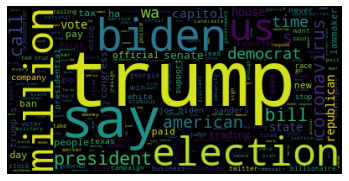

In [134]:
wc = WordCloud().generate('Title'.join(df['Title']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')

In [135]:
# genrate the token list:
token1 = ' '.join(df.Title).split()

In [136]:
# creating the bigrams
ngrams_2 = nltk.bigrams(token1)

# freq distribution for these
freq_2grams = pd.Series(ngrams_2).value_counts().to_dict()
list(freq_2grams.items())[:20]

[(('joe', 'biden'), 11),
 (('donald', 'trump'), 9),
 (('bernie', 'sanders'), 9),
 (('supreme', 'court'), 6),
 (('alexandria', 'ocasiocortez'), 5),
 (('ted', 'cruz'), 5),
 (('marjorie', 'taylor'), 4),
 (('trump', 'administration'), 4),
 (('trump', 'campaign'), 4),
 (('ban', 'stock'), 4),
 (('president', 'trump'), 4),
 (('taylor', 'greene'), 4),
 (('capitol', 'riot'), 4),
 (('member', 'congress'), 4),
 (('president', 'donald'), 4),
 (('elizabeth', 'warren'), 4),
 (('bill', 'would'), 3),
 (('president', 'trump’s'), 3),
 (('report', 'say'), 3),
 (('stacey', 'abrams'), 3)]

In [137]:
# creating the trigrams
ngrams_3 = nltk.trigrams(token1)

# freq distribution for these
freq_3grams = pd.Series(ngrams_3).value_counts().to_dict()
list(freq_3grams.items())[:20]

[(('marjorie', 'taylor', 'greene'), 4),
 (('make', 'election', 'day'), 3),
 (('ban', 'stock', 'trading'), 2),
 (('lawsuit', 'produced', 'exactly'), 2),
 (('us', 'election', 'biden'), 2),
 (('votes', 'impeach', 'president'), 2),
 (('impeach', 'president', 'donald'), 2),
 (('president', 'donald', 'j'), 2),
 (('donald', 'j', 'trump'), 2),
 (('zero', 'evidence', 'fraud'), 2),
 (('exactly', 'zero', 'evidence'), 2),
 (('produced', 'exactly', 'zero'), 2),
 (('campaign', 'lawsuit', 'produced'), 2),
 (('house', 'votes', 'impeach'), 2),
 (('trump', 'campaign', 'lawsuit'), 2),
 (('throws', 'trump', 'campaign'), 2),
 (('judge', 'throws', 'trump'), 2),
 (('georgia', 'judge', 'throws'), 2),
 (('election', 'day', 'holiday'), 2),
 (('elizabeth', 'warren', 'want'), 2)]

In [138]:
# model = trained word2vec model
# data= retrieved data from Reddit
# size = the size given at the time of word2vec embedding i.e in this case 300

def prediction_data_process(model,df,size):
    
    prediction_data=np.asarray(list(df['Title']))
    prediction_data=process(prediction_data)
    cleaned_prediction_data=[]
    for sent in prediction_data:
        cleaned_prediction_data.append(sent.split()) 
        
    vectors = []
    for sent in cleaned_prediction_data:
        sent_vec = np.zeros(size)
        cnt_words = 0
        for word in sent:
            try:
                vec = word2vec_model.wv[word]  # getting the vector corresponding to the word
                sent_vec += vec       # Adding the vectors of all the words present in sentence
                cnt_words += 1        # counting the number of words
            except:
                pass
        if cnt_words!=0:    
            sent_vec /= cnt_words
        vectors.append(sent_vec)
    
    return np.nan_to_num(vectors)

In [139]:
final_prediction_data1=prediction_data_process(word2vec_model,df,300)

100%|██████████| 300/300 [00:00<00:00, 17857.47it/s]


In [140]:
# Saving the processed data

pd.DataFrame(final_prediction_data1).to_csv("Reddit_data.csv")

In [141]:
final_prediction_data1[3][1:10]

array([ 0.06015838,  0.11977232, -0.07718683,  0.13571634,  0.12343043,
        0.12982076,  0.13431885, -0.2572505 ,  0.21326768])

In [142]:
from joblib import Parallel, delayed
import joblib
  
  
# Load the model from the file

RF_Model = joblib.load('Model_Random_Forest.pkl')

In [143]:
RF_Model.predict(final_prediction_data1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [144]:
# creating a list for new column
RF_pred = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
df['RF_pred'] = RF_pred

In [145]:
df

,Title,RF_pred
0,trump falsely claim ha election demand supreme...,0
1,democrat raphael warnock defeated republican k...,0
2,fbi opened inquiry whether trump secretly work...,0
3,petition impeach clarence thomas pass 300000 s...,0
4,impeach justice clarence thomas petition pass ...,0
...,...,...
295,surprise surprise offduty cops country dc capi...,0
296,fbi looking ‘classified nuclear documents’ sea...,0
297,trump thought could convince pence overthrow e...,0
298,biggest question twitter user debate mute mics...,0


In [146]:
Model_XGB = joblib.load('Model_XGB.pkl')

In [147]:
Model_XGB.predict(final_prediction_data1)

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [149]:
XGB_pred = [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
df['XGB_pred'] = XGB_pred

In [150]:
df

,Title,RF_pred,XGB_pred
0,trump falsely claim ha election demand supreme...,0,0
1,democrat raphael warnock defeated republican k...,0,0
2,fbi opened inquiry whether trump secretly work...,0,1
3,petition impeach clarence thomas pass 300000 s...,0,0
4,impeach justice clarence thomas petition pass ...,0,0
...,...,...,...
295,surprise surprise offduty cops country dc capi...,0,0
296,fbi looking ‘classified nuclear documents’ sea...,0,0
297,trump thought could convince pence overthrow e...,0,0
298,biggest question twitter user debate mute mics...,0,0


In [151]:
logreg = joblib.load('Model_logreg.pkl')

In [152]:
logreg.predict(final_prediction_data1)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [153]:
LR_pred = [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
df['LR_pred'] = LR_pred

In [154]:
df

,Title,RF_pred,XGB_pred,LR_pred
0,trump falsely claim ha election demand supreme...,0,0,0
1,democrat raphael warnock defeated republican k...,0,0,0
2,fbi opened inquiry whether trump secretly work...,0,1,1
3,petition impeach clarence thomas pass 300000 s...,0,0,0
4,impeach justice clarence thomas petition pass ...,0,0,0
...,...,...,...,...
295,surprise surprise offduty cops country dc capi...,0,0,0
296,fbi looking ‘classified nuclear documents’ sea...,0,0,0
297,trump thought could convince pence overthrow e...,0,0,0
298,biggest question twitter user debate mute mics...,0,0,0


0    285
1     15
Name: RF_pred, dtype: int64


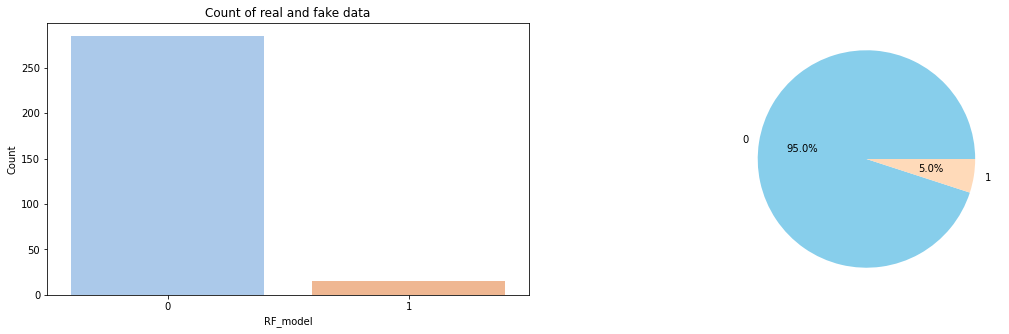

In [155]:
print(df["RF_pred"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df.RF_pred,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("RF_model")
g2 = plt.pie(df["RF_pred"].value_counts().values,explode=[0,0],labels=df.RF_pred.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

0    249
1     51
Name: XGB_pred, dtype: int64


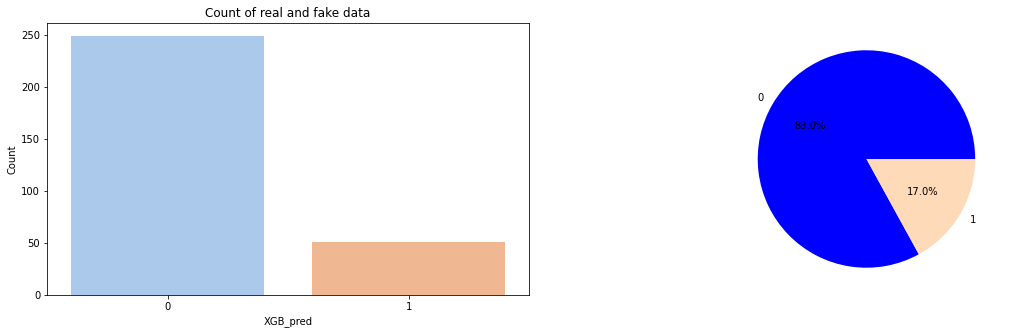

In [156]:
print(df["XGB_pred"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df.XGB_pred,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("XGB_pred")
g2 = plt.pie(df["XGB_pred"].value_counts().values,explode=[0,0],labels=df.XGB_pred.value_counts().index, autopct='%1.1f%%',colors=['Blue','PeachPuff'])
fig.show()

0    229
1     71
Name: LR_pred, dtype: int64


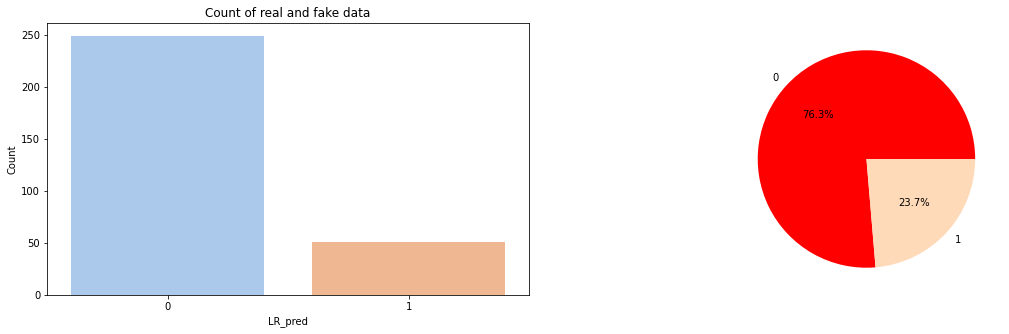

In [157]:
print(df["LR_pred"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df.XGB_pred,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("LR_pred")
g2 = plt.pie(df["LR_pred"].value_counts().values,explode=[0,0],labels=df.LR_pred.value_counts().index, autopct='%1.1f%%',colors=['Red','PeachPuff'])
fig.show()